In [1]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import gym
import matplotlib.pyplot as plt

from abides_gym_market_making_environment_v2 import *
from policies_v1 import SigPolicy
from train_v2 import train
from test_v1_v2 import test
import utils

## Register the environment

In [2]:
# register market making env for gym use 
from gym.envs.registration import register

register(
    id="market-making-v2",
    entry_point=SubGymMarketsMarketMakingEnv_v2,
)

def generate_env(seed=None):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(
            "market-making-v2",
            background_config="rmsc04",
            mkt_close="10:45:00",
            timestep_duration="10s",
            order_fixed_size=10,
            first_interval="00:10:00", #00:13:00
            observe_first_interval=True,
            max_inventory=100,
            mkt_order_alpha=0.2,
            terminal_inventory_reward=2,# reward
            inventory_reward_dampener=1., # 0.6,
            damp_mode="asymmetric",
            debug_mode=False
        )
    if seed is not None:
        env.seed(seed)
    
    return env

# create the environment
env = generate_env(5)

## Train a signature policy

In [3]:
episodes = 2
lr = 0.0001
window_length = None
eps = 1.0
eps_decay = utils.linear_decay(epochs=20_000, start=eps, end=0.02)

sigpolicy = SigPolicy(env, 5)
sigpolicy.initialize_parameters(factor=1, zero_bias=True)

results = train(env, 
                sigpolicy, 
                episodes,
                discount=1.0,
                learning_rate=lr, 
                exploration="greedy",
                epsilon=eps,
                epsilon_decay=eps_decay,
                window_length=window_length, 
                printing=False)

  0%|          | 0/2 [00:00<?, ?it/s]
 Episode 0 | step 100 | reward -0.17080000000000004 | loss 0.1428250180433006
Q values: tensor([-0.0763,  0.0129, -0.0326, -0.1278], grad_fn=<SelectBackward>)

 Episode 0 | step 200 | reward -0.4857000000000001 | loss 0.4000371752328171
Q values: tensor([ 0.0629, -0.0228,  0.0255, -0.0337], grad_fn=<SelectBackward>)

 Episode 0 | step 300 | reward -0.7806500000000003 | loss 0.6817364432468085
Q values: tensor([ 0.1149, -0.0014,  0.1310,  0.0073], grad_fn=<SelectBackward>)

 Episode 0 | step 361 | reward -1.5532000000000004 | loss 0.8403181432775146
Q values: tensor([-0.0650,  0.0013,  0.0524, -0.0159], grad_fn=<SelectBackward>)
 50%|█████     | 1/2 [00:28<00:28, 28.00s/it]
 Episode 1 | step 400 | reward -0.07350000000000001 | loss 0.009355740812734936
Q values: tensor([0.0526, 0.0116, 0.0263, 0.0339], grad_fn=<SelectBackward>)

 Episode 1 | step 500 | reward -0.7997 | loss 0.1222813170025705
Q values: tensor([0.0861, 0.0074, 0.0454, 0.0518], grad_f

#### Plot training results

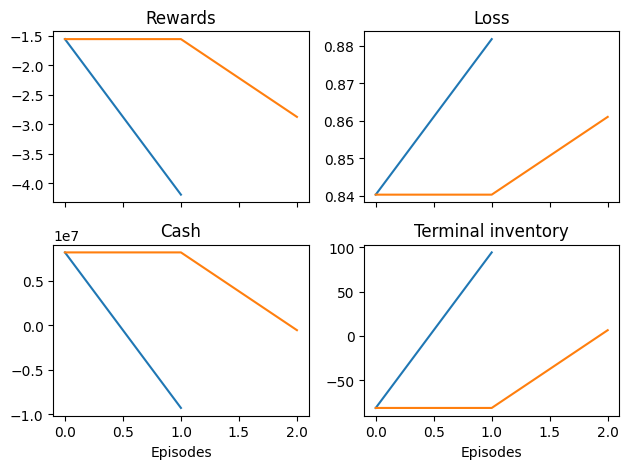

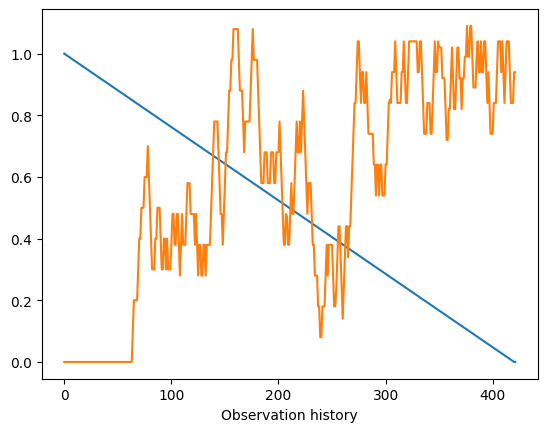

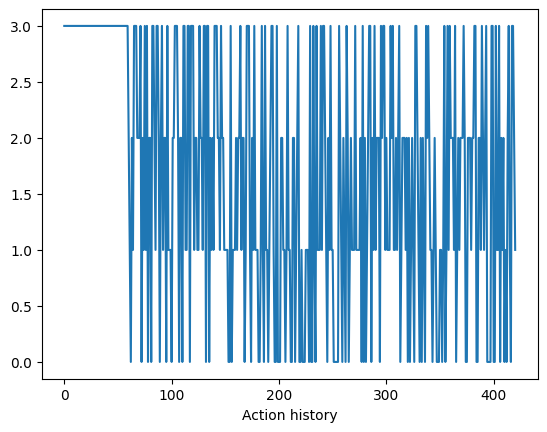

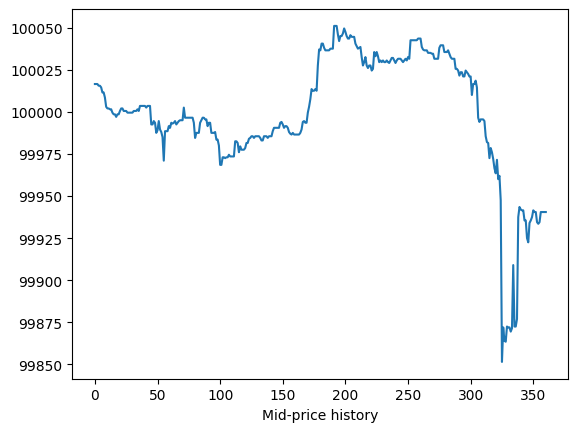

In [5]:

utils.plot_results([
    #results["rewards"],
    [x if abs(x) < 400 else 0 for x in results["rewards"]],
    #results["losses"],
    [x if abs(x) < 2000 else 200 for x in results["losses"]],
    results["cash"],
    results["terminal_inventory"],
])

id = 1

observation_history = list(results["observations"][id])
plt.plot(observation_history)
plt.xlabel("Observation history")
plt.show()

plt.plot(results["actions"][id])
plt.xlabel("Action history")
plt.show()

plt.plot(results["mid_prices"][id])
plt.xlabel("Mid-price history")
plt.show()


#### Save training results

In [ ]:
# results_reduced_100_runs_0804_1  # without inventory reward
# results_reduced_50_runs_0804_2  # with inventory reward
# results_reduced_50_runs_0804_3 # with inventory reward and correct epsilon decay
# results_v2_200_runs_0808_1_convergence # inventory only model, with some convergence
# results_v2_250_runs_0809_1 # inventory only model, with some convergence
# results_v2_250_runs_0809_2 # inventory only model, with some convergence
# results_v2_250_runs_0810_1 # inventory only model, with some convergence

import pickle


# write results 
with open('../results/results_NEW.pkl', 'wb') as f:  # open a text file
    pickle.dump(results, f) # serialize the list
f.close()




## Test a policy

#### Load training results

In [ ]:
# results_reduced_100_runs_0804_1  # without inventory reward
# results_reduced_50_runs_0804_2  # with inventory reward
# results_reduced_50_runs_0804_3 # with inventory reward and correct epsilon decay
# results_v2_200_runs_0808_1_convergence # inventory only model, with some convergence
# results_v2_250_runs_0809_1 # inventory only model, with some convergence
# results_v2_250_runs_0809_2 # inventory only model, with some convergence
# results_v2_250_runs_0810_1 # inventory only model, with some convergence

import pickle

# load results
with open('../results/results_v2_250_runs_0810_1.pkl', 'rb') as f:
    results = pickle.load(f)
f.close()

checkpoint = -1
sigpolicy = SigPolicy(env, 5)
sigpolicy.load_state_dict(results["intermediate"][checkpoint])

#### Run tests

In [ ]:
runs = 10
env = generate_env()

test_results = test(env, sigpolicy, runs, epsilon=0)

#### Plot testing results

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False)
for ax, id, count in zip(axes.flat, order, range(4)):
    ax.set_title(names[id])
    ax.plot(results[id])
    ax.plot(moving_average(results[id], window))
    if count > 1:
        ax.set_xlabel('Episodes')
    fig.tight_layout()
    plt.show()